### Required libraries

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sys
import numpy as np
import os.path as op
from os import mkdir, makedirs, getcwd
import scipy.stats as stats
import nipype.interfaces.fsl as fsl
from subprocess import call, Popen, check_output, CalledProcessError
import nibabel as nib
from shutil import copyfile, rmtree
import scipy.io as sio
from sklearn import cross_validation
from sklearn import linear_model
from numpy.polynomial.legendre import Legendre
import shlex
from scipy import signal
import operator
import gzip
from nilearn.signal import clean
from nilearn.image import smooth_img
from nilearn.input_data import NiftiMasker
import scipy.linalg as linalg
import string
import random
import xml.etree.cElementTree as ET
from time import localtime, strftime, sleep
from scipy.fftpack import fft, dct
from scipy.spatial.distance import pdist, squareform


### Parameters

In [ ]:
class config(object):
    filtering = []
    doScrubbing = False
    behavFile = 'unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
    release = 'Q2'
    outScore = 'PMAT24_A_CR'
    pipelineName = 'Finn'
    parcellation = 'shenetal_neuroimage2013'
    overwrite = False
    thisRun = 'rfMRI_REST1'
    isDataClean = False
    doPlot = True
    queue = False
    isCifti = False
    keepMean = False
    preWhitening = False
    
# these functions allow Paola & Julien to run code locally with their own path definitions
def getDataDir(x):
    return {
        'esplmatlabw02.csmc.edu': '/home/duboisjx/vault/data/HCP/MRI',
        'sculpin.caltech.edu': '/data/jdubois/data/HCP/MRI',
    }.get(x, '/media/paola/HCP/')    # /media/paola/HCP is default if x not found
def getParcelDir(x):
    return {
        'esplmatlabw02.csmc.edu': '/home/duboisjx/vault/data/parcellations/',
        'sculpin.caltech.edu': '/data/jdubois/data/parcellations/',
    }.get(x, '/data/pgaldi/parcellations/')    # /home/paola/parcellations/ is default if x not found
import socket
HOST=socket.gethostname()
DATADIR=getDataDir(HOST)
PARCELDIR=getParcelDir(HOST)    

# customize path to get access to single runs
def buildpath(subject,fmriRun):
    return op.join(DATADIR, subject,'MNINonLinear','Results',fmriRun)

#DATADIR = '/media/paola/HCP/'
#PARCELDIR = '/home/paola/parcellations'

if config.queue: priority=-100

if config.thisRun == 'rfMRI_REST1':
    outMat = 'rest_1_mat'
elif config.thisRun == 'rfMRI_REST2':
    outMat = 'rest_1_mat'
else:
    sys.exit("Invalid run code")  
    
suffix = '_hp2000_clean' if config.isDataClean else '' 

### Pipeline definition

The pipeline workflow is defined by two dictionaries. 

The struct <b>Operations</b> encodes the order of generic pipeline steps, with 0 for skipping an operation, and otherwise a number indicating when the operation should be performed. Note that several operations may have the same position (e.g., motion regression and tissue regression may both have order = 3, which means they should be performed in the same regression). For each operation an array encodes the flavor of each step and parameters when needed.

#### Finn's pipeline

In [286]:
Operations= [
    ['VoxelNormalization',      1, ['zscore']],
    ['Detrending',              2, ['legendre', 3, 'WMCSF']],
    ['TissueRegression',        3, ['WMCSF']],
    ['MotionRegression',        4, ['[R dR]']],
    ['TemporalFiltering',       5, ['Gaussian', 1]],
    ['Detrending',              6, ['legendre', 3,'GM']],
    ['GlobalSignalRegression',  7, []],
    ['Scrubbing',               0, ['FD', 0.2, 1]],
    ['SpatialSmoothing',        0, ['Gaussian', 6]],
]

### Utils

In [ ]:
# regressors: to filter, no. time points x no. regressors
def filter_regressors(regressors, filtering, nTRs, TR):
    if len(filtering)==0:
        print 'Error! Missing or wrong filtering flavor. Regressors were not filtered.'
    else:
        if filtering[0] == 'Butter':
            regressors = clean(regressors, detrend=False, standardize=False, 
                                  t_r=TR, high_pass=filtering[1], low_pass=filtering[2])
        elif filtering[0] == 'Gaussian':
            w = signal.gaussian(11,std=filtering[1])
            regressors = signal.lfilter(w,1,regressors, axis=0)  
    return regressors
    
def regress(niiImg, nTRs, TR, regressors, keepMean=False, preWhitening=False):    
    if preWhitening:
        W = prewhitening(niiImg, nTRs, TR, regressors)
        niiImg = np.dot(niiImg,W)
        regressors = np.dot(W,regressors)
    X  = np.concatenate((np.ones([nTRs,1]), regressors), axis=1)
    N = niiImg.shape[0]
    for i in range(N):
        fit = np.linalg.lstsq(X, niiImg[i,:].T)[0]
        fittedvalues = np.dot(X, fit)
        resid = niiImg[i,:] - np.ravel(fittedvalues)
        if keepMean:
            niiImg[i,:] = X[:,0]*fit[0] + resid
        else:
            niiImg[i,:] = resid
    return niiImg     

def normalize(niiImg,flavor):
    if flavor == 'zscore':
        niiImg = stats.zscore(niiImg, axis=1, ddof=1)
        return niiImg
    elif flavor == 'pcSigCh':
        niiImg = 100 * (niiImg - np.mean(niiImg,axis=1)[:,np.newaxis]) / np.mean(niiImg,axis=1)[:,np.newaxis]
    else:
        print 'Warning! Wrong normalization flavor. Nothing was done'
    return niiImg    

def legendre_poly(order, nTRs):
    # ** a) create polynomial regressor **
    x = np.arange(nTRs)
    x = x - x.max()/2
    num_pol = range(order+1)
    y = np.ones((len(num_pol),len(x)))   
    coeff = np.eye(order+1)
    # Print out text file for each polynomial to be used as a regressor
    for i in num_pol:
        myleg = Legendre(coeff[i])
        y[i,:] = myleg(x) 
        if i>0:
            y[i,:] = y[i,:] - np.mean(y[i,:])
            y[i,:] = y[i,:]/np.max(y[i,:])
        np.savetxt(op.join(buildpath(subject,fmriRun),
                           'poly_detrend_legendre' + str(i) + '.txt'), y[i,:] ,fmt='%.4f')
    return y

def load_img(fmriFile, maskAll):
    if config.isCifti:
        toUnzip = fmriFile.replace('_Atlas.dtseries.nii','.nii.gz')
        cmd = 'wb_command -cifti-convert -to-text {} {}'.format(fmriFile,op.join(buildpath(subject,fmriRun),'.tsv'))
        call(cmd,shell=True)
    else:
        toUnzip = fmriFile

    with open(toUnzip, 'rb') as fFile:
        decompressedFile = gzip.GzipFile(fileobj=fFile)
        outFilePath = op.join(buildpath(subject, fmriRun), fmriRun+'.nii')
        with open(outFilePath, 'wb') as outfile:
            outfile.write(decompressedFile.read())

    volFile = outFilePath

    img = nib.load(volFile)
    
    myoffset = img.header.sizeof_hdr + 4 + img.header.get_data_offset()
    data = np.memmap(volFile, dtype=img.header.get_data_dtype(), mode='c', order='F',
                     offset=myoffset,shape=img.header.get_data_shape())

    nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
    TR = img.header.structarr['pixdim'][4]
    niiImg = data.reshape([nRows*nCols*nSlices, nTRs], order='F')
    niiImg = niiImg[maskAll,:]
    return niiImg, nRows, nCols, nSlices, nTRs, img.affine, TR

def plot_hist(score,title,xlabel):
    h,b = np.histogram(score, bins='auto')
    plt.hist(score,bins=b)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    return h

def makeTissueMasks(subject,fmriRun,overwrite):
    fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+suffix+'.nii.gz')
    WMmaskFileout = op.join(buildpath(subject,fmriRun), 'WMmask.nii')
    CSFmaskFileout = op.join(buildpath(subject,fmriRun), 'CSFmask.nii')
    GMmaskFileout = op.join(buildpath(subject,fmriRun), 'GMmask.nii')
    
    if not op.isfile(GMmaskFileout) or overwrite:
        # load ribbon.nii.gz and wmparc.nii.gz
        ribbonFilein = op.join(DATADIR, subject, 'MNINonLinear','ribbon.nii.gz')
        wmparcFilein = op.join(DATADIR, subject, 'MNINonLinear', 'wmparc.nii.gz')
        # make sure it is resampled to the same space as the functional run
        ribbonFileout = op.join(buildpath(subject,fmriRun), 'ribbon.nii.gz')
        wmparcFileout = op.join(buildpath(subject,fmriRun), 'wmparc.nii.gz')
        # make identity matrix to feed to flirt for resampling
        with open('eye.mat','w') as fid:
            fid.write('1 0 0 0\n0 1 0 0\n0 0 1 0\n0 0 0 1')
        
        flirt_ribbon = fsl.FLIRT(in_file=ribbonFilein, out_file=ribbonFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_ribbon.run()

        flirt_wmparc = fsl.FLIRT(in_file=wmparcFilein, out_file=wmparcFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_wmparc.run()
        
        # load nii (ribbon & wmparc)
        ribbon = nib.load(ribbonFileout).get_data()
        wmparc = nib.load(wmparcFileout).get_data()
        
        # white & CSF matter mask
        # indices are from FreeSurferColorLUT.txt
        
        # Left-Cerebral-White-Matter, Right-Cerebral-White-Matter
        ribbonWMstructures = [2, 41]
        # Left-Cerebral-Cortex, Right-Cerebral-Cortex
        ribbonGMstrucures = [3, 42]
        # Cerebellar-White-Matter-Left, Brain-Stem, Cerebellar-White-Matter-Right
        wmparcWMstructures = [7, 16, 46]
        # Left-Cerebellar-Cortex, Right-Cerebellar-Cortex, Thalamus-Left, Caudate-Left
        # Putamen-Left, Pallidum-Left, Hippocampus-Left, Amygdala-Left, Accumbens-Left 
        # Diencephalon-Ventral-Left, Thalamus-Right, Caudate-Right, Putamen-Right
        # Pallidum-Right, Hippocampus-Right, Amygdala-Right, Accumbens-Right
        # Diencephalon-Ventral-Right
        wmparcGMstructures = [8, 47, 10, 11, 12, 13, 17, 18, 26, 28, 49, 50, 51, 52, 53, 54, 58, 60]
        # Fornix, CC-Posterior, CC-Mid-Posterior, CC-Central, CC-Mid-Anterior, CC-Anterior
        wmparcCCstructures = [250, 251, 252, 253, 254, 255]
        # Left-Lateral-Ventricle, Left-Inf-Lat-Vent, 3rd-Ventricle, 4th-Ventricle, CSF
        # Left-Choroid-Plexus, Right-Lateral-Ventricle, Right-Inf-Lat-Vent, Right-Choroid-Plexus
        wmparcCSFstructures = [4, 5, 14, 15, 24, 31, 43, 44, 63]
        
        # make masks
        WMmask = np.double(np.logical_and(np.logical_and(np.logical_or(np.logical_or(np.in1d(ribbon, ribbonWMstructures),
                                                                              np.in1d(wmparc, wmparcWMstructures)),
                                                                np.in1d(wmparc, wmparcCCstructures)),
                                                  np.logical_not(np.in1d(wmparc, wmparcCSFstructures))),
                                   np.logical_not(np.in1d(wmparc, wmparcGMstructures))))
        CSFmask = np.double(np.in1d(wmparc, wmparcCSFstructures))
        GMmask = np.double(np.logical_or(np.in1d(ribbon,ribbonGMstrucures),np.in1d(wmparc,wmparcGMstructures)))
        
        # write masks
        ref = nib.load(wmparcFileout)
        WMmask = np.reshape(WMmask,ref.shape)
        img = nib.Nifti1Image(WMmask, ref.affine)
        nib.save(img, WMmaskFileout)
        
        CSFmask = np.reshape(CSFmask,ref.shape)
        img = nib.Nifti1Image(CSFmask, ref.affine)
        nib.save(img, CSFmaskFileout)
        
        GMmask = np.reshape(GMmask,ref.shape)
        img = nib.Nifti1Image(GMmask, ref.affine)
        nib.save(img, GMmaskFileout)
        
        # delete temporary files
        cmd = 'rm eye.mat ribbon_flirt.mat wmparc_flirt.mat'
        call(cmd,shell=True)
        
        
    tmpnii = nib.load(WMmaskFileout)
    myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
    data = np.memmap(WMmaskFileout, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F',
                     offset=myoffset,shape=tmpnii.header.get_data_shape())
    nRows, nCols, nSlices = tmpnii.header.get_data_shape()
    maskWM = np.reshape(data > 0,nRows*nCols*nSlices, order='F')
    del data
    tmpnii = nib.load(CSFmaskFileout)
    myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
    data = np.memmap(CSFmaskFileout, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F', 
                     offset=myoffset,shape=tmpnii.header.get_data_shape())
    maskCSF = np.reshape(data > 0,nRows*nCols*nSlices, order='F')
    del data
    tmpnii = nib.load(GMmaskFileout)
    myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
    data = np.memmap(GMmaskFileout, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F', 
                     offset=myoffset,shape=tmpnii.header.get_data_shape())
    maskGM = np.reshape(data > 0,nRows*nCols*nSlices, order='F')
    del data
    maskAll = np.logical_or(np.logical_or(maskWM, maskCSF), maskGM)
    maskWM_ = maskWM[maskAll]
    maskCSF_ = maskCSF[maskAll]
    maskGM_ = maskGM[maskAll]
    
    return maskAll, maskWM_, maskCSF_, maskGM_


def extract_noise_components(niiImg, WMmask, CSFmask, num_components=5, extra_regressors=None):
    """Largely based on https://github.com/nipy/nipype/blob/master/examples/
    rsfmri_vol_surface_preprocessing_nipy.py#L261
    Derive components most reflective of physiological noise according to
    aCompCor method (Behzadi 2007)
    Parameters
    ----------
    niiImg: raw data
    num_components: number of components to use for noise decomposition
    extra_regressors: additional regressors to add
    Returns
    -------
    components: n_time_points x regressors
    """
    niiImgWMCSF = niiImg[np.logical_or(WMmask,CSFmask),:] 
    
    niiImgWMCSF[np.isnan(np.sum(niiImgWMCSF, axis=1)), :] = 0
    # remove mean and normalize by variance
    # voxel_timecourses.shape == [nvoxels, time]
    X = niiImgWMCSF.T
    stdX = np.std(X, axis=0)
    stdX[stdX == 0] = 1.
    stdX[np.isnan(stdX)] = 1.
    stdX[np.isinf(stdX)] = 1.
    X = (X - np.mean(X, axis=0)) / stdX
    u, _, _ = linalg.svd(X, full_matrices=False)
    components = u[:, :num_components]
    
    if extra_regressors:
        components = np.hstack((components, regressors))

    return components

def conf2XML(inFile, dataDir, operations, startTime, endTime, fname):
    doc = ET.Element("pipeline")
    
    nodeInput = ET.SubElement(doc, "input")
    nodeInFile = ET.SubElement(nodeInput, "inFile")
    nodeInFile.text = inFile
    nodeDataDir = ET.SubElement(nodeInput, "dataDir")
    nodeDataDir.text = dataDir
    
    nodeDate = ET.SubElement(doc, "date")
    nodeDay = ET.SubElement(nodeDate, "day")
    day = strftime("%Y-%m-%d", localtime())
    nodeDay.text = day
    stime = strftime("%H:%M:%S", startTime)
    etime = strftime("%H:%M:%S", endTime)
    nodeStart = ET.SubElement(nodeDate, "timeStart")
    nodeStart.text = stime
    nodeEnd = ET.SubElement(nodeDate, "timeEnd")
    nodeEnd.text = etime
    
    nodeSteps = ET.SubElement(doc, "steps")
    for op in operations:
        if op[1] == 0: continue
        nodeOp = ET.SubElement(nodeSteps, "operation", name=op[0])
        nodeOrder = ET.SubElement(nodeOp, "order")
        nodeOrder.text = str(op[1])
        nodeFlavor = ET.SubElement(nodeOp, "flavor")
        nodeFlavor.text = str(op[2])
    tree = ET.ElementTree(doc)
    tree.write(fname)
    
def fnSubmitToCluster(strScript, strJobFolder, strJobUID, resources):
    specifyqueue = ''
    # clean up .o and .e
    tmpfname = op.join(strJobFolder,strJobUID)
    if op.isfile(tmpfname+'.e'): remove(tmpfname+'.e')       
    if op.isfile(tmpfname+'.o'): remove(tmpfname+'.o')       
   
    strCommand = 'qsub {} -cwd -V {} -N {} -e "{}" -o "{}" "{}"'.format(specifyqueue,resources,strJobUID,
                      op.join(strJobFolder,strJobUID+'.e'), op.join(strJobFolder,strJobUID+'.o'), strScript)
    # write down the command to a file in the job folder
    with open(op.join(strJobFolder,strJobUID+'.cmd'),'w+') as hFileID:
        hFileID.write(strCommand+'\n')
    # execute the command
    cmdOut = check_output(strCommand, shell=True)
    return cmdOut.split()[2]    

def _interpolate(a, b, fraction):
    """Returns the point at the given fraction between a and b, where
    'fraction' must be between 0 and 1.
    """
    return a + (b - a)*fraction;

def scoreatpercentile(a, per, limit=(), interpolation_method='fraction'):
    """
    This function is grabbed from scipy

    """
    values = np.sort(a, axis=0)
    if limit:
        values = values[(limit[0] <= values) & (values <= limit[1])]

    idx = per /100. * (values.shape[0] - 1)
    if (idx % 1 == 0):
        score = values[idx]
    else:
        if interpolation_method == 'fraction':
            score = _interpolate(values[int(idx)], values[int(idx) + 1],
                                 idx % 1)
        elif interpolation_method == 'lower':
            score = values[np.floor(idx)]
        elif interpolation_method == 'higher':
            score = values[np.ceil(idx)]
        else:
            raise ValueError("interpolation_method can only be 'fraction', " \
                             "'lower' or 'higher'")

    return score

def dctmtx(N):
    K=N
    n = range(N)
    C = np.zeros((len(n), K))
    C[:,0] = np.ones((len(n)))/np.sqrt(N)
    doublen = [2*x+1 for x in n]
    for k in range(1,K):
        C[:,k] = np.sqrt(2/N)*np.cos([np.pi*x*(k-1)/(2*N) for x in doublen])        
    return C 

# from nipy
def orth(X, tol=1.0e-07):
    """
    
    Compute orthonormal basis for the column span of X.
    
    Rank is determined by zeroing all singular values, u, less
    than or equal to tol*u.max().
    INPUTS:
        X  -- n-by-p matrix
    OUTPUTS:
        B  -- n-by-rank(X) matrix with orthonormal columns spanning
              the column rank of X
    """

    B, u, _ = linalg.svd(X, full_matrices=False)
    nkeep = np.greater(u, tol*u.max()).astype(np.int).sum()
    return B[:,:nkeep]

def reml(sigma, components, design=None, n=1, niter=128,
         penalty_cov=np.exp(-32), penalty_mean=0):
    """
    Adapted from spm_reml.m
    ReML estimation of covariance components from sigma using design matrix.
    INPUTS:
        sigma        -- m-by-m covariance matrix
        components   -- q-by-m-by-m array of variance components
                        mean of sigma is modeled as a some over components[i]
        design       -- m-by-p design matrix whose effect is to be removed for
                        ReML. If None, no effect removed (???)
        n            -- degrees of freedom of sigma
        penalty_cov  -- quadratic penalty to be applied in Fisher algorithm.
                        If the value is a float, f, the penalty is
                        f * identity(m). If the value is a 1d array, this is
                        the diagonal of the penalty. 
        penalty_mean -- mean of quadratic penalty to be applied in Fisher
                        algorithm. If the value is a float, f, the location
                        is f * np.ones(m).
    OUTPUTS:
        C            -- estimated mean of sigma
        h            -- array of length q representing coefficients
                        of variance components
        cov_h        -- estimated covariance matrix of h
    """

    # initialise coefficient, gradient, Hessian

    Q = components
    PQ = np.zeros(Q.shape)
    
    q = Q.shape[0]
    m = Q.shape[1]

    # coefficient
    h = np.array([np.diag(Q[i]).mean() for i in range(q)])

    ## SPM initialization
    ## h = np.array([np.any(np.diag(Q[i])) for i in range(q)]).astype(np.float)

    C = np.sum([h[i] * Q[i] for i in range(Q.shape[0])], axis=0)

    # gradient in Fisher algorithm
    
    dFdh = np.zeros(q)

    # Hessian in Fisher algorithm
    dFdhh = np.zeros((q,q))

    # penalty terms

    penalty_cov = np.asarray(penalty_cov)
    if penalty_cov.shape == ():
        penalty_cov = penalty_cov * np.identity(q)
    elif penalty_cov.shape == (q,):
        penalty_cov = np.diag(penalty_cov)
        
    penalty_mean = np.asarray(penalty_mean)
    if penalty_mean.shape == ():
        penalty_mean = np.ones(q) * penalty_mean
        
    # compute orthonormal basis of design space

    if design is not None:
        X = orth(design)
    else:
        X = None

    _iter = 0
    _F = np.inf
    
    while True:

        # Current estimate of mean parameter

        iC = linalg.inv(C + np.identity(m) / np.exp(32))

        # E-step: conditional covariance 

        if X is not None:
            iCX = np.dot(iC, X)
            Cq = linalg.inv(np.dot(X.T, iCX))
            P = iC - np.dot(iCX, np.dot(Cq, iCX.T))
        else:
            P = iC

        # M-step: ReML estimate of hyperparameters
 
        # Gradient dF/dh (first derivatives)
        # Expected curvature (second derivatives)

        U = np.identity(m) - np.dot(P, sigma) / n

        for i in range(q):
            PQ[i] = np.dot(P, Q[i])
            dFdh[i] = -(PQ[i] * U).sum() * n / 2

            for j in range(i+1):
                dFdhh[i,j] = -(PQ[i]*PQ[j]).sum() * n / 2
                dFdhh[j,i] = dFdhh[i,j]
                
        # Enforce penalties:

        dFdh  = dFdh  - np.dot(penalty_cov, h - penalty_mean)
        dFdhh = dFdhh - penalty_cov

        dh = linalg.solve(dFdhh, dFdh)
        h -= dh
        C = np.sum([h[i] * Q[i] for i in range(Q.shape[0])], axis=0)
        
        df = (dFdh * dh).sum()
        if np.fabs(df) < 1.0e-01:
            break

        _iter += 1
        if _iter >= niter:
            break

    return C, h, -dFdhh

def sqrtm(V):
    u, s, _  = linalg.svd(V)
    s = np.sqrt(np.abs(np.diag(s)))
    m = s.shape[0]
    return np.dot(u, np.dot(s, u.T))

def prewhitening(niiImg, nTRs, TR, X):
    T = np.arange(nTRs) * TR
    d = 2 ** (np.floor(np.arange(np.log2(TR/4), 7)))
    Q = np.array([linalg.toeplitz((T**j)*np.exp(-T/d[i])) for i in range(len(d)) for j in [0,1]])
    CY = np.cov(niiImg.T)
    V, h, _ = reml(CY, Q, design=X, n=1)
    W = linalg.inv(sqrtm(V))
    return W

### Pipeline setup

Every step is associated with a function.

In [287]:
def MotionRegression(niiImg, flavor, masks, imgInfo):
    # assumes that data is organized as in the HCP
    motionFile = op.join(buildpath(subject,fmriRun), 'Movement_Regressors_dt.txt')
    data = np.genfromtxt(motionFile)
    if flavor[0] == 'R':
        X = data[:,:6]
    elif flavor[0] == 'R dR':
        X = data
    elif flavor[0] == 'R R^2':
        data_squared = data ** 2
        X = np.concatenate((data, data_squared), axis=1)
    elif flavor[0] == 'R R^2 R-1 R-1^2':
        data_roll = np.roll(data, 1, axis=0)
        data_squared = data ** 2
        data_roll[0] = 0
        data_roll_squared = data_roll ** 2
        X = np.concatenate((data, data_squared, data_roll, data_roll_squared), axis=1)
    elif flavor[0] == 'R R^2 R-1 R-1^2 R-2 R-2^2':
        data_roll = np.roll(data, 1, axis=0)
        data_squared = data ** 2
        data_roll[0] = 0
        data_roll_squared = data_roll ** 2
        data_roll2 = np.roll(data_roll, 1, axis=0)
        data_roll2[0] = 0
        data_roll2_squared = data_roll2 ** 2
        X = np.concatenate((data, data_squared, data_roll, data_roll_squared, data_roll2, data_roll2_squared), axis=1)
    else:
        print 'Wrong flavor, using default regressors: R dR'
        X = data
        
    # if filtering has already been performed, regressors need to be filtered too
    if len(config.filtering)>0:
        nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
        X = filter_regressors(X, config.filtering, nTRs, TR)  
        
    if config.doScrubbing:
        nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
        toCensor = np.loadtxt(op.join(buildpath(subject,fmriRun), 'Censored_TimePoints.txt'), dtype=np.dtype(np.int32))
        toReg = np.zeros((nTRs, 1))
        toReg[toCensor] = 1
        X = np.concatenate((X, toReg), axis=1)
        
    return X

def Scrubbing(niiImg, flavor, masks, imgInfo):
    thr = flavor[1]

    if flavor[0] == 'DVARS':
        # pcSigCh
        meanImg = np.mean(niiImg,axis=1)[:,np.newaxis]
        niiImg2 = 100 * (niiImg - meanImg) / meanImg
        niiImg2[np.where(np.isnan(niiImg2))] = 0
        dt = np.diff(niiImg2, n=1, axis=1)
        dt = np.concatenate((np.zeros((dt.shape[0],1)), dt), axis=1)
        score = np.sqrt(np.mean(dt**2,0))        
    elif flavor[0] == 'FD':
        motionFile = op.join(buildpath(subject,fmriRun), 'Movement_Regressors_dt.txt')
        dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
        headradius=50 #50mm as in Powers et al. 2012
        disp=dmotpars.copy()
        disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
        score=np.sum(disp,1)
    else:
        print 'Wrong scrubbing flavor. Nothing was done'
        return niiImg
    
    censored = np.where(score>thr)
    
    if len(flavor)>2:
        pad = flavor[2]
        a_minus = [i-k for i in censored[0] for k in range(1, pad+1)]
        a_plus  = [i+k for i in censored[0] for k in range(1, pad+1)]
        censored = np.concatenate((censored[0], a_minus, a_plus))
        censored = np.unique(censored[np.where(np.logical_and(censored>=0, censored<len(score)))])
    
    np.savetxt(op.join(buildpath(subject,fmriRun), 'Censored_TimePoints.txt'), censored, delimiter='\n', fmt='%d')
    config.doScrubbing = True
    return niiImg

def TissueRegression(niiImg, flavor, masks, imgInfo):
    maskAll, maskWM_, maskCSF_, maskGM_ = masks
    nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
    
    if config.isCifti:
        niiImgGM = niiImg
    else:
        niiImgGM = niiImg[maskGM_,:]
        
    if flavor[0] == 'CompCor':
        X = extract_noise_components(niiImg, maskWM_, maskCSF_, num_components=flavor[1])
        niiImgGM = regress(niiImgGM, nTRs, TR, X, config.keepMean, config.preWhitening)
    elif flavor[0] == 'WMCSF':
        meanWM = np.mean(np.float64(niiImg[maskWM_,:]),axis=0)
        meanWM = meanWM - np.mean(meanWM)
        meanWM = meanWM/max(meanWM)
        meanCSF = np.mean(np.float64(niiImg[maskCSF_,:]),axis=0)
        meanCSF = meanCSF - np.mean(meanCSF)
        meanCSF = meanCSF/max(meanCSF)
        X  = np.concatenate((meanWM[:,np.newaxis], meanCSF[:,np.newaxis]), axis=1)
        niiImgGM = regress(niiImgGM, nTRs, TR, X, config.keepMean, config.preWhitening)
    elif flavor[0] == 'WMCSF+dt':
        meanWM = np.mean(np.float64(niiImg[maskWM_,:]),axis=0)
        meanWM = meanWM - np.mean(meanWM)
        meanWM = meanWM/max(meanWM)
        meanCSF = np.mean(np.float64(niiImg[maskCSF_,:]),axis=0)
        meanCSF = meanCSF - np.mean(meanCSF)
        meanCSF = meanCSF/max(meanCSF)
        dtWM=np.zeros(meanWM.shape)
        dtWM[1:] = np.diff(meanWM, n=1)
        dtCSF=np.zeros(meanCSF.shape)
        dtCSF[1:] = np.diff(meanCSF, n=1)
        X  = np.concatenate((meanWM[:,np.newaxis], meanCSF[:,np.newaxis], 
                             dtWM[:,np.newaxis], dtCSF[:,np.newaxis]), axis=1)
        niiImgGM = regress(niiImgGM, nTRs, TR, X, config.keepMean, config.preWhitening)
    else:
        print 'Warning! Wrong tissue regression flavor. Nothing was done'
    if not config.isCifti:
        niiImg[maskGM_,:] = niiImgGM
    else:
        niiImg = niiImgGM
    return niiImg

def Detrending(niiImg, flavor, masks, imgInfo):
    maskAll, maskWM_, maskCSF_, maskGM_ = masks
    nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
    
    if flavor[2] == 'WMCSF':
        niiImgWMCSF = niiImg[np.logical_or(maskWM_,maskCSF_),:]
        if flavor[0] == 'legendre':
            y = legendre_poly(flavor[1],nTRs)                
            niiImgWMCSF = regress(niiImgWMCSF, nTRs, TR, y[1:4,:].T, config.keepMean, config.preWhitening)
        elif flavor[0] == 'poly':       
            x = np.arange(nTRs)
            nPoly = flavor[1] + 1
            y = np.ones((nPoly,len(x)))
            for i in range(nPoly):
                y[i,:] = (x - (np.max(x)/2)) **(i+1)
                y[i,:] = y[i,:] - np.mean(y[i,:])
                y[i,:] = y[i,:]/np.max(y[i,:]) 
            niiImgWMCSF = regress(niiImgWMCSF, nTRs, TR, y[1:4,:].T, config.keepMean, config.preWhitening)
        else:
            print 'Warning! Wrong detrend flavor. Nothing was done'
        niiImg[np.logical_or(maskWM_,maskCSF_),:] = niiImgWMCSF    
    elif flavor[2] == 'GM':
        if config.isCifti:
            niiImgGM = niiImg
        else:
            niiImgGM = niiImg[maskGM_,:]

        if flavor[0] == 'legendre':
            y = legendre_poly(flavor[1], nTRs)
            niiImgGM = regress(niiImgGM, nTRs, TR, y[1:4,:].T, config.keepMean, config.preWhitening)
        elif flavor[0] == 'poly':       
            x = np.arange(nTRs)
            nPoly = flavor[1] + 1
            y = np.ones((nPoly,len(x)))
            for i in range(nPoly):
                y[i,:] = (x - (np.max(x)/2)) **(i+1)
                y[i,:] = y[i,:] - np.mean(y[i,:])
                y[i,:] = y[i,:]/np.max(y[i,:])
            niiImgGM = regress(niiImgGM, nTRs, TR, y[1:4,:].T, keepMean, config.preWhitening)
        else:
            print 'Warning! Wrong detrend flavor. Nothing was done'

        if not config.isCifti:
            niiImg[maskGM_,:] = niiImgGM
        else:
            niiImg = niiImgGM
    else:
        print 'Warning! Wrong detrend mask. Nothing was done' 
    return niiImg     

   

def SpatialSmoothing(niiImg, flavor, masks, imgInfo):
    maskAll, maskWM_, maskCSF_, maskGM_ = masks
    nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
    
    niiimg = np.zeros((nRows*nCols*nSlices, nTRs))
    niiimg[maskAll,:] = niiImg
    niiimg = np.reshape(niiimg, (nRows, nCols, nSlices, nTRs), order='F')
    newimg = nib.Nifti1Image(niiimg, affine)
    if flavor[0] == 'Gaussian':
        newimg = smooth_img(newimg, flavor[1])
        niiimg = np.reshape(newimg.get_data(), (nRows*nCols*nSlices, nTRs), order='F')
        niiImg = niiimg[maskAll,:]
    elif flavor[0] == 'GaussianGM':
        GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii')
        masker = NiftiMasker(mask_img=GMmaskFile, sessions=None, smoothing_fwhm=flavor[1])
        niiImg[maskGM_,:] = masker.fit_transform(newimg).T
    else:
        print 'Warning! Wrong smoothing flavor. Nothing was done'
    return niiImg  

def TemporalFiltering(niiImg, flavor, masks, imgInfo):
    maskAll, maskWM_, maskCSF_, maskGM_ = masks
    nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
    
    if flavor[0] == 'Butter':
        niiImg = clean(niiImg.T, detrend=False, standardize=False, 
                              t_r=TR, high_pass=flavor[1], low_pass=flavor[2]).T
    elif flavor[0] == 'Gaussian':
        w = signal.gaussian(11,std=flavor[1])
        niiImg = signal.lfilter(w,1,niiImg)
    elif flavor[0] == 'DCT':
        K = dctmtx(nTRs)
        HPC = 1/flavor[1]
        LPC = 1/flavor[2]
        nHP = np.fix(2*(nTRs*TR)/HPC + 1)
        nLP = np.fix(2*(nTRs*TR)/LPC + 1)
        K = K[:,np.concatenate((range(1,nHP),range(int(nLP)-1,nTRs)))]
        return K
    else:
        print 'Warning! Wrong temporal filtering flavor. Nothing was done'    
        return niiImg
    config.filtering = flavor
    return niiImg    
    
def GlobalSignalRegression(niiImg, flavor, masks, imgInfo):
    meanAll = np.mean(niiImg,axis=0)
    meanAll = meanAll - np.mean(meanAll)
    meanAll = meanAll/max(meanAll)
    return meanAll[:,np.newaxis]

def VoxelNormalization(niiImg, flavor, masks, imgInfo):
    if flavor[0] == 'zscore':
        niiImg = stats.zscore(niiImg, axis=1, ddof=1)
        return niiImg
    elif flavor[0] == 'pcSigCh':
        niiImg = 100 * (niiImg - np.mean(niiImg,axis=1)[:,np.newaxis]) / np.mean(niiImg,axis=1)[:,np.newaxis]
    else:
        print 'Warning! Wrong normalization flavor. Nothing was done'
    return niiImg 




Hooks={
    'MotionRegression'       : MotionRegression,
    'Scrubbing'              : Scrubbing,
    'TissueRegression'       : TissueRegression,
    'Detrending'             : Detrending,
    'SpatialSmoothing'       : SpatialSmoothing,
    'TemporalFiltering'      : TemporalFiltering,  
    'GlobalSignalRegression' : GlobalSignalRegression,  
    'VoxelNormalization'     : VoxelNormalization,
}

sortedOperations = sorted(Operations, key=operator.itemgetter(1))
steps = {}
Flavors = {}
cstep = 0

# If requested, scrubbing is performed first, before any denoising step
scrub_idx = -1
curr_idx = -1
for opr in sortedOperations:
    curr_idx = curr_idx+1
    if opr[0] == 'Scrubbing' and opr[1] != 1 and opr[1] != 0:
        scrub_idx = opr[1]
        break
        
if scrub_idx != -1:        
    for opr in sortedOperations:  
        if opr[1] != 0 and opr[1] < scrub_idx:
            opr[1] = opr[1]+1

    sortedOperations[curr_idx][1] = 1       

for opr in sortedOperations:
    if opr[1]==0:
        continue
    else:
        if opr[1]!=cstep:
            cstep=cstep+1
            steps[cstep] = [opr[0]]
            Flavors[cstep] = [opr[2]]
        else:
            steps[cstep].append(opr[0])
            Flavors[cstep].append(opr[2])
                        

Steps are executed sequentially. 

In case of regression, when multiple regression steps have the same order, all the regressors are combined and a single regression is executed (other operations are executed in order).

Tissue regression has a custom handling, since regression is constrained to GM voxels.

If filtering based on Discrete Cosine Transform (DCT) is involved, regression is used for band pass filtering.

In [ ]:
def runPipeline(subject, fmriRun, fmriFile):
    
    timeStart = localtime()
    
    if config.parcellation=='shenetal_neuroimage2013':
        uniqueParcels = range(268)
        config.isCifti = 0
        parcelVolume = 'fconn_atlas_150_2mm.nii'
    elif config.parcellation=='Glasser_Aseg_Suit':
        config.isCifti = 1
        parcelVolume = 'Parcels.dlabel.nii'
        uniqueParcels = range(405)
    else:
        print "Invalid parcellation code"
        return
    
    print 'Step 0'
    print 'Building WM, CSF and GM masks...'
    masks = makeTissueMasks(subject,fmriRun,config.overwrite)
    maskAll, maskWM_, maskCSF_, maskGM_ = masks

    print 'Loading data in memory...'
    imgInfo = load_img(fmriFile, maskAll)
    niiImg, nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
    nsteps = len(steps)
    for i in range(1,nsteps+1):
        step = steps[i]
        print 'Step '+str(i)+' '+str(step[0])
        
        if len(step) == 1:
            # Atomic operations
            if 'Regression' in step[0] or ('TemporalFiltering' in step[0] and 'DCT' in Flavors[i][0]):
                if step[0]=='TissueRegression': #regression constrained to GM
                    niiImg = Hooks[step[0]](niiImg, Flavors[i][0], masks, imgInfo[1:])
                else:
                    r0 = Hooks[step[0]](niiImg, Flavors[i][0], masks, imgInfo[1:])
                    niiImg = regress(niiImg, nTRs, TR, r0, config.keepMean, config.preWhitening)
            else:
                niiImg = Hooks[step[0]](niiImg, Flavors[i][0], masks, imgInfo[1:])
        else:
            # When multiple regression steps have the same order, all the regressors are combined
            # and a single regression is performed (other operations are executed in order)
            r = np.empty((nTRs, 0))
            for j in range(len(step)):
                opr = step[j]
                if 'Regression' in opr or ('TemporalFiltering' in opr and 'DCT' in Flavors[i][j]):
                    if opr=='TissueRegression': #regression constrained to GM
                        niiImg = Hooks[opr](niiImg, Flavors[i][j], masks, imgInfo[1:])
                    else:    
                        r0 = Hooks[opr](niiImg, Flavors[i][j], masks, imgInfo[1:])
                        r = np.append(r, r0, axis=1)
                else:
                    niiImg = Hooks[opr](niiImg, Flavors[i][j], masks, imgInfo[1:])
            if r.shape[1] > 0:
                niiImg = regress(niiImg, nTRs, TR, r, config.keepMean, config.preWhitening)    
        niiImg[np.isnan(niiImg)] = 0

    print 'Done! Copy the resulting file...'
    rstring = ''.join(random.SystemRandom().choice(string.ascii_lowercase +string.ascii_uppercase + string.digits) for _ in range(8))
    outFile = fmriRun+'_'+rstring
    if config.isCifti:
        # write to text file
        np.savetxt(op.join(buildpath(subject,fmriRun),outfile+'.tsv'),niiImg, delimiter='\t', fmt='%.6f')
        # need to convert back to cifti
        cmd = 'wb_command -cifti-convert -from-text {} {} {}'.format(op.join(buildpath(subject,fmriRun),'.tsv'),
                                                                     fmriFile,
                                                                     op.join(buildpath(subject,fmriRun),outFile+'.dtseries.nii'))
        call(cmd,shell=True)
        # delete temporary files
        cmd = 'rm -r {}/*.tsv'.format(buildpath(subject,fmriRun))
        call(cmd,shell=True)
        del niiImg
    else:
        niiimg = np.zeros((nRows*nCols*nSlices, nTRs))
        niiimg[maskAll,:] = niiImg
        del niiImg
        niiimg = np.reshape(niiimg, (nRows, nCols, nSlices, nTRs), order='F')
        newimg = nib.Nifti1Image(niiimg, affine)
        nib.save(newimg,op.join(buildpath(subject,fmriRun),outFile+'.nii.gz'))
        del niiimg 

    timeEnd = localtime()  
    
    outXML = rstring+'.xml'
    conf2XML(fmriFile, DATADIR, sortedOperations, timeStart, timeEnd, op.join(buildpath(subject,fmriRun),outXML))
    
    print 'Preprocessing complete. Starting FC computation...'
    # After preprocessing, functional connectivity is computed
    ResultsDir = op.join(DATADIR,'Results')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,config.pipelineName)
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,config.parcellation)
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    
    for iParcel in uniqueParcels:
        if not config.isCifti:
            parcelMaskFile = op.join(PARCELDIR,config.parcellation,'parcel{:03d}.nii.gz'.format(iParcel+1))
            if not op.isfile(parcelMaskFile):
                print 'Making a binary volume mask for each parcel'
                mymaths1 = fsl.maths.MathsCommand(in_file=op.join(PARCELDIR, config.parcellation,'fconn_atlas_150_2mm.nii'),\
                    out_file=parcelMaskFile, args='-thr {:.1f} -uthr {:.1f}'.format(iParcel+1-0.1, iParcel+1+0.1)) 
                mymaths1.run()
    if not op.isfile(fmriFile):
        print fmriFile, 'does not exist'
        return
    
    tsDir = op.join(buildpath(subject,fmriRun),config.parcellation)
    if not op.isdir(tsDir): mkdir(tsDir)
    alltsFile = op.join(ResultsDir,subject+'_'+fmriRun+'.txt')
    
    if not (op.isfile(alltsFile)) or config.overwrite:            
        # calculate signal in each of the nodes by averaging across all voxels/grayordinates in node
        print 'Extracting mean data from',str(len(uniqueParcels)),'parcels for ',outFile
       
        for iParcel in uniqueParcels:
            tsFile = op.join(tsDir,'parcel{:03d}.txt'.format(iParcel+1))
            if not op.isfile(tsFile):
                if not config.isCifti:
                    parcelMaskFile = op.join(PARCELDIR,config.parcellation,'parcel{:03d}.nii.gz'.format(iParcel+1))
                    
                    # simply average the voxels within the mask
                    meants1 = fsl.ImageMeants(in_file=op.join(buildpath(subject,fmriRun),outFile+'.nii.gz'), out_file=tsFile, mask=parcelMaskFile)
                    meants1.run()
                else:
                    # extract data in the parcel
                    parcelMaskFile = op.join(PARCELDIR,config.parcellation,'parcel{:03d}.dscalar.nii'.format(iParcel+1))
                    cmd = 'wb_command -cifti-label-to-roi {} {} -key {}'.format(
                        op.joinpath(PARCELDIR,config.parcellation,parcelVolume), parcelMaskFile,iParcel+1)
                    call(cmd,shell=True)
                    cmd = 'wb_command -cifti-roi-average {} {} -cifti-roi {}'.format(
                        op.join(buildpath(subject,fmriRun),outFile+'.nii.gz'),tsFile, parcelMaskFile)
                
        # concatenate all ts
        print 'Concatenating data'
        cmd = 'paste '+op.join(tsDir,'parcel*.txt')+' > '+alltsFile
        call(cmd, shell=True)

    
    

### Get subjects

### Exclusion of high-motion subjects
Further exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)

In [ ]:
ResultsDir = op.join(DATADIR,'Results')
if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, config.pipelineName)
if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, config.parcellation)
if not op.isdir(ResultsDir): mkdir(ResultsDir)

PEdirs = ['LR', 'RL']
RelRMSMean = np.zeros([len(subjects), 2])
excludeSub = list()

for iSub in range(len(subjects)):
    subject = str(subjects[iSub])
    RelRMSMeanFile = op.join(buildpath(subject, config.thisRun+'_zz'), 'Movement_RelativeRMS_mean.txt')
    fLR = RelRMSMeanFile.replace('zz','LR');
    fRL = RelRMSMeanFile.replace('zz','RL');
    
    if op.isfile(fLR) & op.isfile(fRL):
        with open(fLR,'r') as tmp:
            RelRMSMean[iSub,0] = float(tmp.read())
        with open(fRL,'r') as tmp:
            RelRMSMean[iSub,1] = float(tmp.read())
        print '{} {:.3f} {:.3f}'.format(subjects[iSub], RelRMSMean[iSub,0], RelRMSMean[iSub,1])
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            print subjects[iSub], ': too much motion, exclude'
            excludeSub.append(iSub)
            continue
    

    for iPEdir in range(len(PEdirs)):
        PEdir=PEdirs[iPEdir]
        fmriRun = config.thisRun+'_'+PEdir
        if config.parcellation=='shenetal_neuroimage2013':
            fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+suffix+'.nii.gz')
            config.isCifti=0
        elif config.parcellation=='Glasser_Aseg_Suit':
            fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+'_Atlas'+suffix+'.dtseries.nii')
            config.isCifti=1
        else:
            print 'Wrong parcellation code'
            return
        if not op.isfile(fmriFile):
            print str(subjects[iSub]), 'missing', fmriFile, ', exclude'
            excludeSub.append(iSub)
            continue
        
        if not (op.isfile(op.join(ResultsDir, str(subjects[iSub])+'_'+config.thisRun+'_'+PEdir+'.txt'))) or config.overwrite:
            print 'load and preprocess'
            if config.queue:
                # make a script to load and preprocess that file, then save as .mat
                jobDir = op.join(buildpath(str(subjects[iSub]),config.thisRun+'_'+PEdir),'jobs')
                if not op.isdir(jobDir): mkdir(jobDir)
                thispythonfn = '<< END\nimport sys\nsys.path.insert(0,"{}")\n'.format(getcwd())
                thispythonfn +='from runPipeline import *\nrunPipeline("{}","{}","{}")\nEND'.format(subject,fmriRun,fmriFile)
                thispythonfn += 'subject = "{}"\n'.format(subject)
                thispythonfn += 'fmriRun = "{}"\n'.format(fmriRun)
                thispythonfn += 'runPipeline("{}","{}","{}")\nEND'.format(subject,fmriRun,fmriFile)
                        
                jobName = 's{}_{}_{}_{}'.format(subjects[iSub],config.thisRun,PEdir, config.pipelineName)
                # prepare a script
                thisScript=op.join(jobDir,jobName+'.sh')
                with open(thisScript,'w') as fidw:
                    fidw.write('#!/bin/bash\n')
                    fidw.write('echo ${FSLSUBALREADYRUN}\n')
                    fidw.write('python {}'.format(thispythonfn))
                cmd='chmod 774 '+thisScript
                call(cmd,shell=True)
                # call to fnSubmitToCluster
                JobID = fnSubmitToCluster(thisScript,jobDir, jobName, '-p {} -l h_vmem=20G'.format(priority))
                joblist.append(JobID)
            else:
                runPipeline(subject, fmriRun, fmriFile)
        else:
            print subject[iSub], ' : ', PEdir, 'results already computed; skipping'

indkeep = np.setdiff1d(range(len(subjects)),excludeSub, assume_unique=True)

Wait for all processes to complete, before resuming pipeline execution.

In [ ]:
if config.queue:
    if len(joblist) != 0:
        while True:
            nleft = len(joblist)
            for i in range(nleft):
                myCmd = "qstat | grep ' {} '".format(joblist[i])
                isEmpty = False
                try:
                    cmdOut = check_output(myCmd, shell=True)
                except CalledProcessError as e:
                    isEmpty = True
                finally:
                    if isEmpty:
                        nleft = nleft-1
            if nleft == 0:
                break
            sleep(10)          

In [ ]:
plt.scatter(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),c='b')
plt.scatter(score[excludeSub],np.mean(RelRMSMean[excludeSub,:],axis=1),c='r')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),1)
z2 = np.polyfit(score,np.mean(RelRMSMean,axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[indkeep])
fit2 = p2(score)
# get the coordinates for the fit curve
c1_x = [np.min(score[indkeep]),np.max(score[indkeep])]
c1_y = p1(c1_x)
c2_x = [np.min(score),np.max(score)]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1))
rho2,p2 = stats.pearsonr(score,np.mean(RelRMSMean,axis=1))                         
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)

### Correlation matrices

Correlate all pairs of node timecourses, resulting in 268x268 matrix of r-values.

Apply Fisher transform to obtain 268x268 matrix of z-scores. The LR and RL runs are never concatenated. Rather, we run the above pipeline on each run separately and average the two resulting matrices of z-scores.

In [ ]:
if config.parcellation=='shenetal_neuroimage2013':
    nParcels = 268
elif config.parcellation=='Glasser_Aseg_Suit':
    nParcels = 405
corrmats = np.zeros([nParcels,nParcels,len(indkeep)])
scores = np.zeros([len(indkeep)])
index = 0
for iSub in range(len(subjects)):
    if iSub not in excludeSub:
        PEdir=PEdirs[iPEdir] 
        tsFile_LR=op.join(ResultsDir,str(subjects[iSub])+'_'+config.thisRun+'_LR.txt')
        tsFile_RL=op.join(ResultsDir,str(subjects[iSub])+'_'+config.thisRun+'_RL.txt')
        ts_LR = np.loadtxt(tsFile_LR)
        ts_RL = np.loadtxt(tsFile_RL)
        # Fisher z transform of correlation coefficients
        corrMat_LR = np.arctanh(np.corrcoef(ts_LR,rowvar=0))
        corrMat_RL = np.arctanh(np.corrcoef(ts_RL,rowvar=0))
        np.fill_diagonal(corrMat_LR,1)
        np.fill_diagonal(corrMat_RL,1)
        corrmats[:,:,index] = (corrMat_LR + corrMat_RL)/2
        scores[index] = score[iSub]
        index = index + 1
        
results = {}
results[outMat] = corrmats
results[config.outScore] = scores
sio.savemat(op.join(ResultsDir,'{}_HCP_{}.mat'.format(config.thisRun,config.release)),results)

### Behavioral prediction

In [30]:
toLoad = 'rfMRI_REST1_HCP_Q2_jd'
data = sio.loadmat(toLoad)

## INPUTS
all_mats = data['rest_1_mat']
all_behav = data['PMAT24_A_CR']

# threshold for feature selection
thresh = 0.01

no_sub = all_mats.shape[2]
no_node = all_mats.shape[0]

behav_pred_pos = np.zeros([no_sub,1])
behav_pred_neg = np.zeros([no_sub,1])

triu_idx = np.triu_indices(no_node,1)
n_edges = len(triu_idx[1]);

edges = np.zeros([no_sub,n_edges])

for subject in range(all_mats.shape[-1]):
    edges[subject,] = all_mats[:,:,subject][triu_idx]

In [31]:
n_subj = all_mats.shape[2]
gF = all_behav

In [32]:
gF.shape

(115, 1)

In [33]:
from sklearn import cross_validation
from sklearn import linear_model
loo = cross_validation.LeaveOneOut(n_subj)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])

p=0.01
score = all_behav

i=0
for train_index, test_index in loo:
    pears = [stats.pearsonr(np.squeeze(edges[train_index,j]),np.squeeze(gF[train_index])) for j in range(0,n_edges)]
    # select edges (positively and negatively) correlated with gF with threshold p
    idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
    idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
    filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
    filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
    # compute network statistic for each subject in training
    strength_pos = filtered_pos.sum(axis=1) 
    strength_neg = filtered_neg.sum(axis=1)
    # compute network statistic for test subject
    str_pos_test = edges[test_index,idx_filtered_pos].sum()
    str_neg_test = edges[test_index,idx_filtered_neg].sum()
    # regression
    lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
    predictions_pos[i] = lr_pos.predict(str_pos_test)
    lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
    predictions_neg[i] = lr_neg.predict(str_neg_test) 
    errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
    errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
    i=i+1
        


In [ ]:
loo = cross_validation.LeaveOneOut(no_sub)
lr = linear_model.LinearRegression()
predictions_pos = np.zeros([no_sub,1])
predictions_neg = np.zeros([no_sub,1])

for train_index, test_index in loo:
    # leave out subject from matrices and behaviour
    train_mats = all_mats[:,:,train_index]
    train_vcts = np.reshape(train_mats, [-1,train_mats.shape[2]])
    train_behav = all_behav[train_index]
    vcts_len = train_vcts.shape[0]
    # correlate all edges with behavior
    pears = [stats.pearsonr(train_vcts[i,:],np.squeeze(train_behav)) 
             for i in range(vcts_len)]
    # set threshold and define masks
    idx_filtered_pos = np.array([idx for idx in range(vcts_len) 
                                 if pears[idx][1]<thresh and pears[idx][0]>0])
    idx_filtered_neg = np.array([idx for idx in range(vcts_len) 
                                 if pears[idx][1]<thresh and pears[idx][0]<0])
    filtered_pos = train_vcts[idx_filtered_pos,:]
    filtered_neg = train_vcts[idx_filtered_neg,:]
    # get sum of all edges in TRAIN subs (divide by 2 to control
    # for the fact that matrices are symmetric)
    train_sumpos = filtered_pos.sum(axis=0)/2 
    train_sumneg = filtered_neg.sum(axis=0)/2
    # build model on TRAIN subs
    z_pos = np.polyfit(train_sumpos,np.squeeze(train_behav),1)
    p = np.poly1d(z_pos)
    fit_pos = p(train_sumpos)
    z_neg = np.polyfit(train_sumneg,np.squeeze(train_behav),1)
    p = np.poly1d(z_neg)
    fit_neg = p(train_sumneg)
    # run model on TEST sub
    test_mats = all_mats[:,:,test_index]
    test_vec = np.reshape(test_mats, [-1,test_mats.shape[2]])
    test_sumpos = test_vec[idx_filtered_pos].sum()/2
    test_sumneg = test_vec[idx_filtered_neg].sum()/2
    behav_pred_pos[test_index] = z_pos[0] * test_sumpos + z_pos[1]
    behav_pred_neg[test_index] = z_neg[0] * test_sumneg + z_neg[1]
    lr_pos = lr.fit(train_sumpos.reshape(-1,1),train_behav)
    predictions_pos[test_index] = lr_pos.predict(test_sumpos)
    lr_neg = lr.fit(train_sumneg.reshape(-1,1),train_behav)
    predictions_neg[test_index] = lr_neg.predict(test_sumneg) 

In [609]:
# compare predicted and observed score
R_pos,P_pos = stats.pearsonr(np.squeeze(behav_pred_pos),np.squeeze(all_behav))
R_neg,P_neg = stats.pearsonr(np.squeeze(behav_pred_neg),np.squeeze(all_behav))    

In [23]:
all_behav.shape

(115, 1)

In [24]:
# compare predicted and observed score
R_pos,P_pos = stats.pearsonr(np.squeeze(predictions_pos),np.squeeze(all_behav))
R_neg,P_neg = stats.pearsonr(np.squeeze(predictions_neg),np.squeeze(all_behav))

0.108769057627


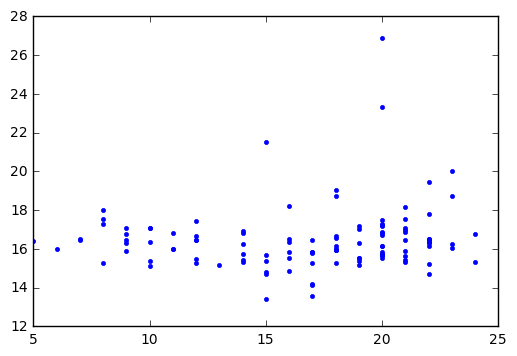

In [606]:
plt.figure()
plt.plot(all_behav,predictions_pos,'b.')
print(R_pos)

0.108769057627


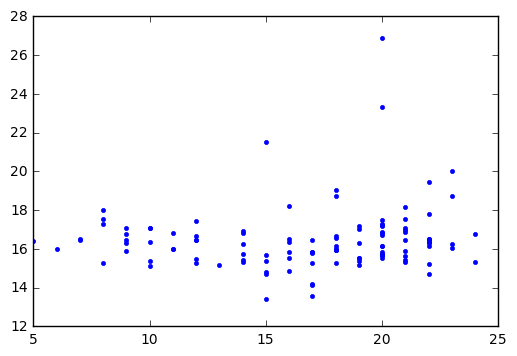

In [611]:
plt.figure()
plt.plot(all_behav,behav_pred_pos,'b.')
print(R_pos)

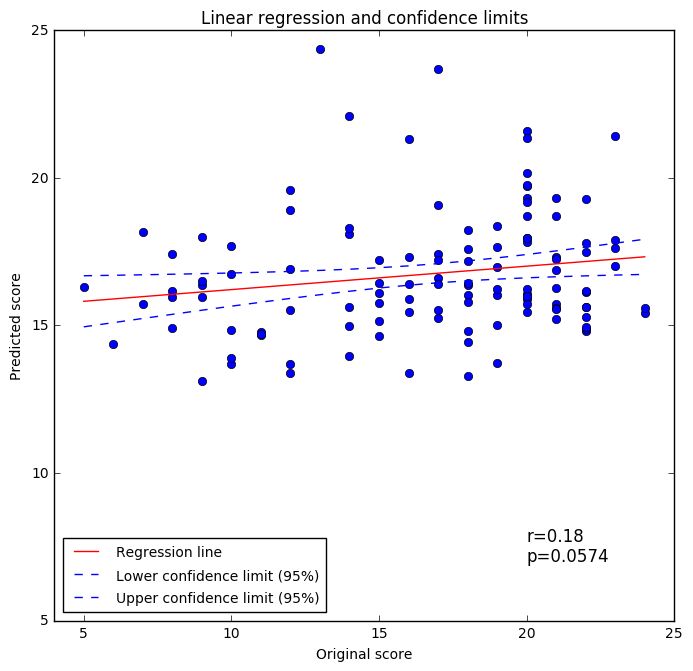

In [27]:
x = np.ravel(gF)
y = np.ravel(predictions_pos)


# fit a curve to the data using a least squares 1st order polynomial fit
z = np.polyfit(x,y,1)

p = np.poly1d(z)
fit = p(x)
 
# get the coordinates for the fit curve
c_x = [np.min(x),np.max(x)]
c_y = p(c_x)
 
# predict y values of origional data using the fit
p_y = z[0] * x + z[1]
 
# calculate the y-error (residuals)
y_err = y - p_y
 
# create series of new test x-values to predict for
p_x = np.arange(np.min(x),np.max(x)+1,1)
 
# now calculate confidence intervals for new test x-series
mean_x = np.mean(x)         # mean of x
n = len(x)              # number of samples in origional fit
DF = n_subj - z.size                            # degrees of freedom
t = stats.t.ppf(0.95, DF)           # used for CI and PI bands
s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
 
#confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
# now predict y based on test x-values
p_y = z[0]*p_x+z[1]
 
# get lower and upper confidence limits based on predicted y and confidence intervals
lower = p_y - abs(confs)
upper = p_y + abs(confs)
 
# set-up the plot
plt.subplots(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlabel('Original score')
plt.ylabel('Predicted score')
plt.title('Linear regression and confidence limits')
 
# plot sample data
plt.plot(x,y,'bo')
 
# plot line of best fit
plt.plot(c_x,c_y,'r-',label='Regression line')
 
# plot confidence limits
plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')
 
# set coordinate limits
plt.xlim(4,25)
plt.ylim(5,25)
 
# configure legend
plt.legend(loc=0)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)

# add text
rho,p = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(gF))
s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
plt.text(20, 7, s, fontsize=12)
 
# show the plot
plt.show()

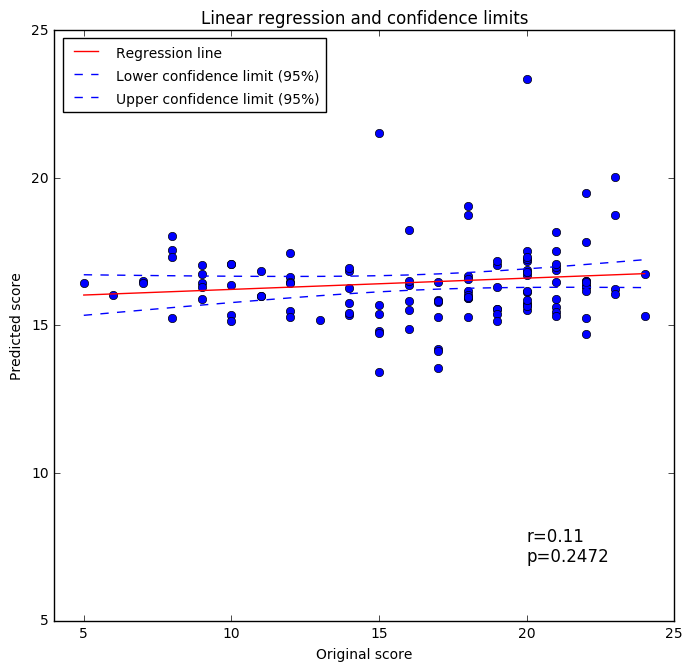

In [34]:
x = np.ravel(gF)
y = np.ravel(predictions_pos)


# fit a curve to the data using a least squares 1st order polynomial fit
z = np.polyfit(x,y,1)

p = np.poly1d(z)
fit = p(x)
 
# get the coordinates for the fit curve
c_x = [np.min(x),np.max(x)]
c_y = p(c_x)
 
# predict y values of origional data using the fit
p_y = z[0] * x + z[1]
 
# calculate the y-error (residuals)
y_err = y - p_y
 
# create series of new test x-values to predict for
p_x = np.arange(np.min(x),np.max(x)+1,1)
 
# now calculate confidence intervals for new test x-series
mean_x = np.mean(x)         # mean of x
n = len(x)              # number of samples in origional fit
DF = n_subj - z.size                            # degrees of freedom
t = stats.t.ppf(0.95, DF)           # used for CI and PI bands
s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
 
#confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
# now predict y based on test x-values
p_y = z[0]*p_x+z[1]
 
# get lower and upper confidence limits based on predicted y and confidence intervals
lower = p_y - abs(confs)
upper = p_y + abs(confs)
 
# set-up the plot
plt.subplots(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.xlabel('Original score')
plt.ylabel('Predicted score')
plt.title('Linear regression and confidence limits')
 
# plot sample data
plt.plot(x,y,'bo')
 
# plot line of best fit
plt.plot(c_x,c_y,'r-',label='Regression line')
 
# plot confidence limits
plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')
 
# set coordinate limits
plt.xlim(4,25)
plt.ylim(5,25)
 
# configure legend
plt.legend(loc=0)
leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=10)

# add text
rho,p = stats.pearsonr(np.ravel(predictions_pos),np.squeeze(gF))
s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
plt.text(20, 7, s, fontsize=12)
 
# show the plot
plt.show()

### Plots

Grayplots

In [293]:
# Frame displacement
motionFile = op.join(buildpath(subject,fmriRun), 'Movement_Regressors_dt.txt')
dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
headradius=50 #50mm as in Powers et al. 2012
disp=dmotpars.copy()
disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
score=np.sum(disp,1)

In [ ]:
outputfile = 'media/paola/HCP/sample_io/rfMRI_REST1_RL_tBTSButt.nii.gz'
subject = '734045'
fmriRun = 'rfMRI_REST1_LR'
fmriFile = op.join(buildpath(subject, fmriRun),fmriRun+'_hp2000_clean.nii.gz')
masks = makeTissueMasks(subject,fmriRun,False)
maskAll, maskWM_, maskCSF_, maskGM_ = masks
imgInfo = load_img(fmriFile, maskAll)
niiImg, nRows, nCols, nSlices, nTRs, affine, TR = imgInfo
X = 100 * (niiImg - np.mean(niiImg,axis=1)[:,np.newaxis]) / np.mean(niiImg,axis=1)[:,np.newaxis]
fig = plt.figure()
ax1 = plt.subplot(211)
plt.plot(np.arange(nTRs),score)
ax2 = plt.subplot(212, sharex=ax1)
im = plt.imshow(X, aspect='auto', interpolation='None', cmap=plt.cm.gray)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

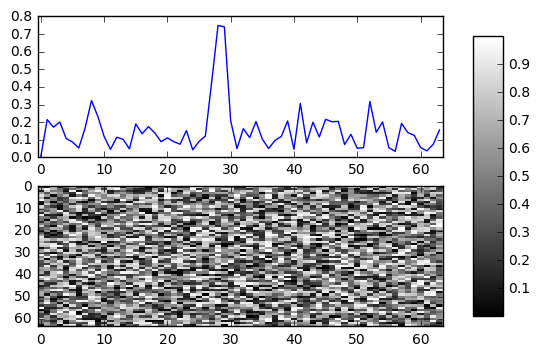

In [544]:
fig = plt.figure()
ax1 = plt.subplot(211)
plt.plot(np.arange(64),score[0:64])
ax2 = plt.subplot(212, sharex=ax1)
im = plt.imshow(np.random.rand(64, 64), aspect='auto', interpolation='None', cmap=plt.cm.gray)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", "50%", pad="3%")
#plt.colorbar(im, cax=cax)
#plt.colorbar(im, use_gridspec=True)
#plt.tight_layout()

#cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
#cb = plt.colorbar(im, cax = cbaxes)  
#plt.show()

QC-RSFC plots

In [451]:
df = pd.read_csv(config.behavFile)

# select subjects according to release
if config.release == 'Q2':
    ind = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    ind = (df['Release'] != 'Q2') & (df['Release'] != 'Q1')
else:
    sys.exit("Invalid release code")
    
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_Compl']== True) & (df['fMRI_Mot_Compl']==True) 
             & (df['fMRI_Lang_Compl']==True) & (df['fMRI_Emo_Compl']==True)         
             & (df['RS-fMRI_Count']==4))
                
df = df[ind]  

# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])

# list of all selected subjects
subjects = df['Subject']

PEdirs = ['LR', 'RL']
RelRMSMean = np.zeros([len(subjects), 2])
excludeSub = list()

for iSub in range(len(subjects)):
    subject = str(subjects[iSub])
    RelRMSMeanFile = op.join(buildpath(subject, config.thisRun+'_zz'), 'Movement_RelativeRMS_mean.txt')
    fLR = RelRMSMeanFile.replace('zz','LR');
    fRL = RelRMSMeanFile.replace('zz','RL');
    
    if op.isfile(fLR) & op.isfile(fRL):
        with open(fLR,'r') as tmp:
            RelRMSMean[iSub,0] = float(tmp.read())
        with open(fRL,'r') as tmp:
            RelRMSMean[iSub,1] = float(tmp.read())
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            excludeSub.append(iSub)
            continue
    
indkeep = np.setdiff1d(range(len(subjects)),excludeSub, assume_unique=True)

#Frame displacement across subjects
fdscores = np.zeros((len(indkeep)))
i=0
for subject in subjects[indkeep]:
    motionFile = op.join(buildpath(str(subject),fmriRun), 'Movement_Regressors_dt.txt')
    dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
    headradius=50 #50mm as in Powers et al. 2012
    disp=dmotpars.copy()
    disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
    fdscores[i]=np.mean(np.sum(disp,1))
    i = i + 1

In [ ]:
parcellation268 = '/home/paola/parcellations/shenetal_neuroimage2013/shen_2mm_268_parcellation.nii.gz'
with open(parcellation268, 'rb') as fFile:
    decompressedFile = gzip.GzipFile(fileobj=fFile)
    outFilePath = '/home/paola/parcellations/shenetal_neuroimage2013/shen_2mm_268_parcellation.nii'
    with open(outFilePath, 'wb') as outfile:
        outfile.write(decompressedFile.read())
tmpnii = nib.load(outFilePath)
myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
data = np.memmap(outFilePath, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F',
                 offset=myoffset,shape=tmpnii.header.get_data_shape())
nRows, nCols, nSlices = tmpnii.header.get_data_shape()
idx_parcels = np.array([np.where(data==i) for i in range(1,269)])

In [336]:
parcel_means = np.array([(point[0].mean(), point[1].mean(), point[2].mean()) for point in idx_parcels])

In [339]:
np.savetxt('parcel_means.csv', parcel_means)

In [342]:
pmeans = np.loadtxt('parcel_means.csv')

In [416]:
edists = squareform(pdist(parcel_means))

In [396]:
triu_idx = np.triu_indices(268,1)

In [454]:
mydata = sio.loadmat('original_data/rfMRI_REST1_HCP_Q2.mat')
restmat = mydata['rest_1_mat']
restmat.shape

(268, 268, 115)

In [478]:
edges_across_subj = restmat[triu_idx[0], triu_idx[1], :]

In [480]:
pears = np.array([stats.pearsonr(edges_across_subj[i],fdscores)[0] for i in range(edges_across_subj.shape[0])])

In [492]:
np.where(edists==min(edists[triu_idx]))

(array([148, 149]), array([149, 148]))

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
plt.scatter(edists[triu_idx]*2, pears)
plt.ylabel('FC-MFD Correlation (r)')
plt.xlabel('Inter-node Euclidean distance (mm)')
plt.xlim([0,200])
plt.axhline(y=0, color='k')


In [518]:
fit = lowess(pears, edists[triu_idx]*2)


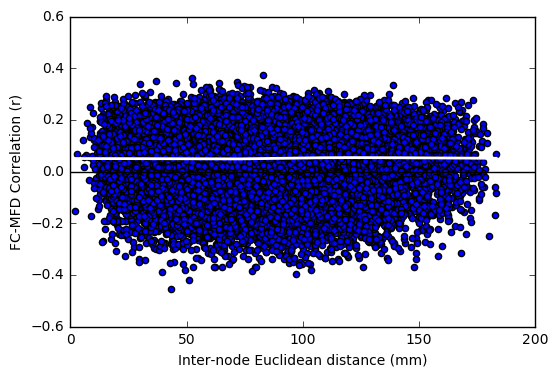

In [521]:
plt.scatter(edists[triu_idx]*2, pears)
plt.ylabel('FC-MFD Correlation (r)')
plt.xlabel('Inter-node Euclidean distance (mm)')
plt.xlim([0,200])
plt.axhline(y=0, color='k')
plt.plot(fit[:,0],fit[:,1],'white',linewidth=2)

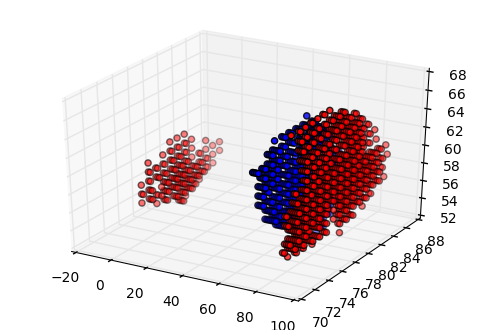

In [498]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(idx_parcels[149][0], idx_parcels[149][1], idx_parcels[149][2])
ax.scatter(idx_parcels[148][0], idx_parcels[148][1], idx_parcels[148][2],c='red')